In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output #Clears output in a notebook
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [ ]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data

dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived') # pop() will remove the "survived" column from the dataframe and return it.
y_eval = dfeval.pop('survived')

In [ ]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [ ]:
dftrain.shape

(627, 9)

<Axes: >

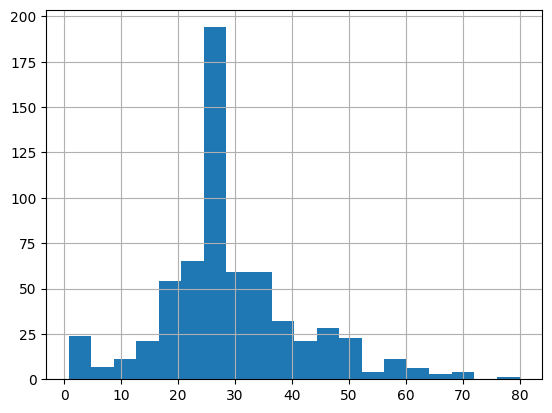

In [ ]:
dftrain.age.hist(bins=20)

<Axes: >

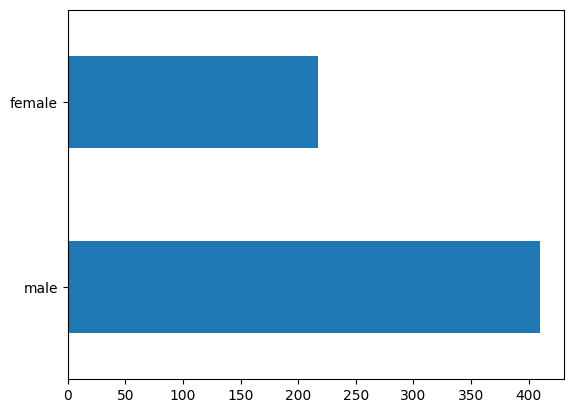

In [ ]:
dftrain['sex'].value_counts().plot(kind='barh') #barh = bar graph, horizontal

<Axes: >

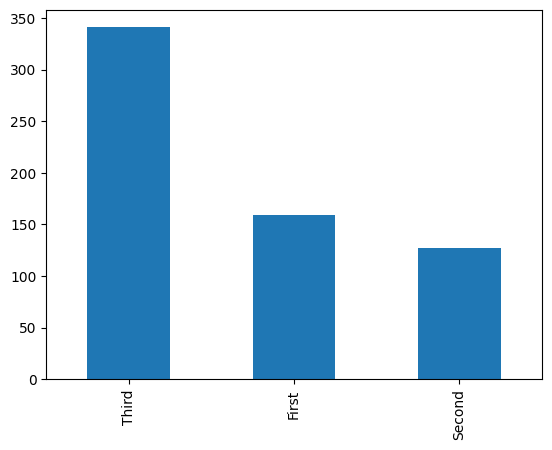

In [ ]:
dftrain['class'].value_counts().plot(kind='bar')

Text(0.5, 0, '%survive')

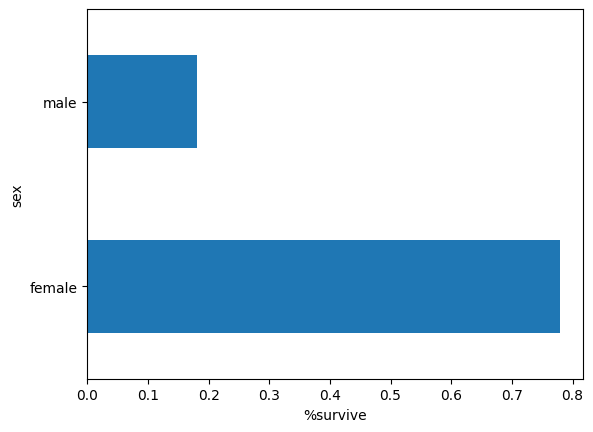

In [ ]:
(pd.concat([dftrain,y_train],axis=1) #concatenates / joins the two dataframes vertically
            .groupby('sex') #groups the resulting dataframe by the 'sex' column
            .survived.mean() #calculates the mean survival rate for each sex
            .plot(kind='barh') #Creates a bar plot
            .set_xlabel('%survive')) #sets an x-axis label of '%survive'

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
#Segregating categorical and numerical data columns

categorical_columns = ['sex','class','deck','embark_town','alone','n_siblings_spouses','parch']

numerical_columns = ['age','fare']

feature_columns = []
for feature_name in categorical_columns:
  vocabulary = dftrain[feature_name].unique() #gets a list of all unique values from given feature column. Example, when 'sex' column is selected, it will give male and female
  print(vocabulary)
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))#creates a column (numpy array type) that has the feature name, and all the vocabularies, that is categories

for feature_name in numerical_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) #creates a column just using the feature name and its data type

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


['male' 'female']
['Third' 'First' 'Second']
['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
['n' 'y']
[1 0 3 4 2 5 8]
[0 1 2 5 3 4]


In [ ]:
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, def

* Epochs: How many times the same data is fed to the model
* Batch: Subsets of the training data that are used to train the model in each iteration of the training process.

###Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object.

The `input function` takes our data and encodes it into a tf.data.dataset object. This is because the model can recognize only ```tf.data.Dataset``` to work.

In [ ]:

#Makes a function and returns the function object
def make_input_fn(data_df, #pandas dataframe
                  label_df, #labels (y_train, eval, etc)
                  num_epochs=10, # number of epochs
                  shuffle=True, #shuffles / mixes up data before passing to model
                  batch_size=32): #no. of subsets

  def input_function():  # inner function, this will be returned
  # below line Creates a tf.data.Dataset object with data and its label
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df) , label_df)) #Passing a dictionary representation of our dataframe || label_df =  y values
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


In [ ]:
train_input_fn = make_input_fn(dftrain,y_train) #passing our dataframe and label
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

##Creating the model

In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns) #understanding: calling a linear classifier from estimator class in tf
# We create a linear estimtor by passing the feature columns we created earlier

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


##Training the model

In [ ]:
linear_est.train(train_input_fn)  # training command
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears console output
result  # the result variable is simply a dict of stats about our model

{'accuracy': 0.7537879,
 'accuracy_baseline': 0.625,
 'auc': 0.80872357,
 'auc_precision_recall': 0.7553336,
 'average_loss': 0.54432046,
 'label/mean': 0.375,
 'loss': 0.53579897,
 'precision': 0.7361111,
 'prediction/mean': 0.2746795,
 'recall': 0.53535354,
 'global_step': 200}

* Increasing epochs can either increase or decrease accuracy
* `evaluate()` is used to evaluate the performance of a trained model
* `predict()` is used to make predictions on new unseen data.

In [ ]:
result =list(linear_est.predict(eval_input_fn)) #making a prediction
result[0] #returns a dictionary for one prediction

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


{'logits': array([-2.8723335], dtype=float32),
 'logistic': array([0.05353829], dtype=float32),
 'probabilities': array([0.94646174, 0.05353829], dtype=float32),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object)}

Our target label is the `probabilities` field.

We need to extract the `probabilities` field

In [ ]:
index = 4

print(dfeval.loc[index]) #printing the data

print(f'Actual result: {y_eval.loc[index]}')

#Printing the survival rate
print(f'''Chance of survival: {result[index]["probabilities"][1]}
Chance of not surviving: {result[index]["probabilities"][0]}''')

sex                          male
age                          34.0
n_siblings_spouses              0
parch                           0
fare                         13.0
class                      Second
deck                            D
embark_town           Southampton
alone                           y
Name: 4, dtype: object
Actual result: 1
Chance of survival: 0.17934079468250275
Chance of not surviving: 0.8206592202186584


#Classification

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import pandas as pd

###Dataset
This specific dataset seperates flowers into 3 different classes of species.
- Setosa
- Versicolor
- Virginica

The information about each flower is the following.
- sepal length
- sepal width
- petal length
- petal width

In [ ]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [ ]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

In [ ]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [ ]:
train_y = train.pop('Species')
test_y = test.pop('Species')

In [ ]:
train_y.head()

0    2
1    1
2    2
3    0
4    0
Name: Species, dtype: int64

In [ ]:
train.shape

(120, 4)

In [ ]:
train.keys()

Index(['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'], dtype='object')

#Input function

In [ ]:
def input_fn(df,label_df,batch_size = 256,training=True):
  dataset = tf.data.Dataset.from_tensor_slices((dict(df), label_df))
  if training:
    dataset=dataset.shuffle(1000).repeat() #shuffle and repeat
  return dataset.batch(batch_size) #batch function is used to return a batch of data from the dataset. The batch size is specified as an argument to the function, and it returns a list of tensors containing the data in the batch.

In [ ]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
  print(key)
  my_feature_columns.append(tf.feature_column.numeric_column(key=key)) #converts to a tensor
my_feature_columns

SepalLength
SepalWidth
PetalLength
PetalWidth


[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

###Building the Model
For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below.
- ```DNNClassifier``` (Deep Neural Network)
- ```LinearClassifier``` (Similar to linear_regression)

We can choose either model but the DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in our data.

In [ ]:
classifier = tf.estimator.DNNClassifier( #the estimator module stores a lot of pre made models. DNNClassifier is one of them
    feature_columns=my_feature_columns,
    hidden_units=[30,10],
    n_classes = 3 #because there are 3 types of classes to classify
    )

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


In [ ]:
classifier.train( #during training/evaluating, we pass both features and labels in input_fn
    input_fn=lambda: input_fn(train,train_y,training=True), #Here we need to pass a function in the input_fn argument, that will return the input function we defined. Since we have directly defined the input function, without a make_input_fn, we use lambda for this task
    steps=5000 #We will go through the dataset until we have looked at 5000 things
)

Instructions for updating:
Use tf.keras instead.


In [ ]:
classifier.evaluate(input_fn=lambda: input_fn(test,test_y,training=False))

{'accuracy': 0.8333333,
 'average_loss': 0.6391598,
 'loss': 0.6391598,
 'global_step': 5000}

##Creating a function for making predictions

In [ ]:
def predict_fn(features, batch_size=256):
  ds = tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)
  return ds


features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict={}

In [ ]:
#Taking input for making predictions:
print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid:
    val = input(feature + ": ")
    if not val.isdigit(): valid = False
#adding the input data to the predict dictionary, which will be used to make predictions
  predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: predict_fn(predict)) #during making predictions, we pass only features,
print(predictions)
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
         SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength: 2.4
SepalWidth: 2.5
PetalLength: 6.6
PetalWidth: 6.9
<generator object Estimator.predict at 0x789b601d5850>
Prediction is "Virginica" (92.4%)


In [ ]:
pred_dict

{'logits': array([-6.402837  , -2.7839549 , -0.25482303], dtype=float32),
 'probabilities': array([0.00197596, 0.07369509, 0.924329  ], dtype=float32),
 'class_ids': array([2]),
 'classes': array([b'2'], dtype=object),
 'all_class_ids': array([0, 1, 2], dtype=int32),
 'all_classes': array([b'0', b'1', b'2'], dtype=object)}

###`class_ids` gives the prediction of the model. here, array[2] means our model thinks it is virginica(index 2 in species array)

#Clustering is an **Unsupervised learning algorithm**

Clustering is a Machine Learning technique that involves the grouping of data points. In theory, data points that are in the same group should have similar properties and/or features, while data points in different groups should have highly dissimilar properties and/or features. (https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)

####Basic Algorithm for K-Means.
- Step 1: Randomly pick K points to place K centroids
- Step 2: Assign all the data points to the centroids by distance. The closest centroid to a point is the one it is assigned to.
- Step 3: Average all the points belonging to each centroid to find the middle of those clusters (center of mass). Place the corresponding centroids into that position.
- Step 4: Reassign every point once again to the closest centroid.
- Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.


##Hidden Markov Models

"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution []. Transitions among the states are governed by a set of probabilities called transition probabilities." (http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html)

A hidden markov model works with probabilities to predict future events or states. In this section we will learn how to create a hidden markov model that can predict the weather.

*This section is based on the following TensorFlow tutorial.* https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel

###Data
Let's start by discussing the type of data we use when we work with a hidden markov model.

In the previous sections we worked with large datasets of 100's of different entries. For a markov model we are only interested in probability distributions that have to do with states.

We can find these probabilities from large datasets or may already have these values. We'll run through an example in a second that should clear some things up, but let's discuss the components of a markov model.

**States:** In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.

**Observations:** Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: *On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.*

**Transitions:** Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: *a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.*

To create a hidden markov model we need.
- States
- Observation Distribution
- Transition Distribution

For our purpose we will assume we already have this information available as we attempt to predict the weather on a given day.

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install tensorflow_probability==0.8.0rc0

  Using cached tensorflow_probability-0.8.0rc0-py2.py3-none-any.whl (2.5 MB)
  Attempting uninstall: tensorflow_probability
    Found existing installation: tensorflow-probability 0.22.0
    Uninstalling tensorflow-probability-0.22.0:
      Successfully uninstalled tensorflow-probability-0.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires tensorflow-probability>=0.13.0, but you have tensorflow-probability 0.8.0rc0 which is incompatible.


In [ ]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time
import tensorflow as tf

ImportError: ignored

###Weather Model
Taken direclty from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel).

We will model a simple weather system and try to predict the temperature on each day given the following information.
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

If you're unfamiliar with **standard deviation** it can be put simply as the range of expected values.

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25.

To model this in TensorFlow we will do the following.
